In [123]:
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [124]:
# Read the file in which the values are saved
appa2 = pd.read_csv("../../exports/appa2_shrinked.csv")
appa2 = appa2.drop('Unnamed: 0', axis=1)

In [125]:
#selecting all the values we need to train and test the model
appa2 = appa2[[
    'LaFeO3_1', 'LaFeO3_2', 
    'STN_1', 'STN_2', 
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'STN_1_heatR', 'STN_2_heatR', 
    "LaFeO3_1_Age", "LaFeO3_2_Age",
    "STN_1_Age","STN_2_Age",
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC', 
    'Wind_Speed', 
    'PM10', 'CO', 'NO2'
]]

# Random Forest

In [126]:
# Select the features
cols = [
    'LaFeO3_1', 'LaFeO3_2', 
    'STN_1', 'STN_2', 
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'STN_1_heatR', 'STN_2_heatR', 
    "LaFeO3_1_Age", "LaFeO3_2_Age",
    "STN_1_Age","STN_2_Age",
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC', 
    'Wind_Speed'
]

# Select the target
outs = ['PM10', 'CO', 'NO2']

In [6]:
# # Split the values in training and test
# vsplit = round(len(appa2) * 0.2)

# X_train = appa2.iloc[vsplit:][cols]
# X_test = appa2.iloc[:vsplit][cols]

# Y_train = appa2.iloc[vsplit:][outs]
# Y_test = appa2.iloc[:vsplit][outs]

In [127]:
features = appa2[cols]
target= appa2[outs]

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [120]:
working_X_train, working_X_test, working_Y_train, working_Y_test = X_train, X_test, Y_train, Y_test

In [80]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start= 1000, stop= 2000, num=10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1500, 1544, 1588, 1633, 1677, 1722, 1766, 1811, 1855, 1900], 'max_features': ['sqrt'], 'max_depth': [103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, None], 'min_samples_split': [4, 5, 8], 'min_samples_leaf': [3, 6, 7], 'bootstrap': [True, False]}


In [81]:
# Choose the type of model
model = RandomForestRegressor()

In [82]:
# Perform the RandomForestRegression with a Random Search on hyperparameters
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                               random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1677; total time=   5.6s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1677; total time=   5.7s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1855; total time=   5.9s
[CV] END bootstrap=True, max_depth=111, max_features=sqrt, min_samples_leaf=7, min_samples_split=4, n_estimators=1855; total time=   5.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1855; total time=   6.1s
[CV] END bootstrap=True, max_depth=113, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=1766; total time=   6.3s
[CV] END bootstrap=True, max_depth=113, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimat

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [103, 104, 105, 106, 107,
                                                      108, 109, 110, 111, 112,
                                                      113, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [3, 6, 7],
                                        'min_samples_split': [4, 5, 8],
                                        'n_estimators': [1500, 1544, 1588, 1633,
                                                         1677, 1722, 1766, 1811,
                                                         1855, 1900]},
                   random_state=42, verbose=2)

In [88]:
# Create a Dataframe with the results of the model and then saving them into a .csv file
ris = pd.DataFrame(rf_random.cv_results_)
ris.to_csv('results/results_weather2_shrinked_working(3).csv')

In [89]:
# Save the model itself in a .sav file
pickle.dump(rf_random, open('models/model_weather2_shrinked_working(3).sav', 'wb'))

## Results

In [113]:
rf_random = pickle.load(open("models/model_weather2_shrinked_working(2).sav", "rb"))
rf_random

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [90, 92, 94, 96, 98, 100,
                                                      102, 104, 106, 108, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [4, 7, 9],
                                        'n_estimators': [1050, 1122, 1194, 1266,
                                                         1338, 1411, 1483, 1555,
                                                         1627, 1700]},
                   random_state=42, verbose=2)

In [108]:
def percentage(mean_abs_err, describer):
    perc = mean_abs_err / (describer.max() - describer.min())
    return perc * 100

In [114]:
print("PM10: " + str(percentage(mean_absolute_error(Y_test.PM10 , rf_random.predict(X_test)[: ,0]), Y_test.PM10) ))
print("CO: " + str(percentage(mean_absolute_error(Y_test.CO , rf_random.predict(X_test)[: ,1]), Y_test.CO)))
print("NO2: " + str(percentage(mean_absolute_error(Y_test.NO2 , rf_random.predict(X_test)[: ,2]), Y_test.NO2)))
print("Total: \n" + str(mean_absolute_error(Y_test, rf_random.predict(X_test))))

PM10: 6.521441088186096
CO: 5.268099553027008
NO2: 7.5494700989450925
Total: 
6.064282207632559


In [ ]:
rf_random.predict(X_test)[:, 0]

array([ 50.80968622,  13.46680309,  12.57389723,  58.01728058,
         6.12323784,   8.46793997,   7.97203274,  19.22874034,
        20.74465666,  23.60027285,  25.01068668,  35.24488404,
         7.98408367,  16.0579809 ,  40.90063665,  57.02023647,
        25.37198727,  25.51455207,  26.17780809,  20.7148704 ,
        14.76830377,  37.87175989,  44.97271487,  40.9258754 ,
        10.35698045,  39.29331514,  38.98931332,  20.58594816,
        21.0788995 ,  29.70645748,  14.92928604,  19.66484766,
        15.92223738,  64.37494316,  23.67439745,  15.22396544,
        53.4533879 ,  29.67803547,  21.00227376,  20.77444293,
        10.75306958,  41.13869941,  19.6530241 ,  35.15370623,
        44.16803092,  32.03819918,  25.2946794 ,  12.74897681,
         5.76011824,  38.95202365,  32.43383356,  17.33810823,
        15.46657572,  16.4049568 ,  26.22828558,  37.98090041,
        18.44247385,   9.97794452,  25.63483402,  11.03433379,
        13.56252842,  11.49795362,  16.23146885,  42.12

In [48]:
# RSS (Residual Sum of Squares) --> it estimates the variance in the residuals
def residual_sum(real, predict):
    rss = 0
    for index in range(len(real)):
        rss += (real[index] - predict[index]) ** 2 
    return rss

# TSS (Total Sum of Squares) --> the squared differences between the observed dependent variable and its mean
def total_sum_square(real):
    tss = 0
    meanR = real.mean()
    for index in range(len(real)):
        tss += (real[index] - meanR) ** 2 
    return tss

# R^2 Coefficient of determination --> Statistical maeasure that represents the proportion of the variance for a dependent variable that's explained by an indipendent variable or variables in a regression model
def r_squared(real, predict):
    value = residual_sum(real, predict)/total_sum_square(real)
    return 1 - value

In [85]:
print(f"PM10: {r2_score(Y_test.PM10, rf_random.predict(X_test)[:, 0])}" ) 
print(f"CO: {r2_score(Y_test.CO, rf_random.predict(X_test)[:, 1])}")
print(f"NO2: {r2_score(Y_test.NO2, rf_random.predict(X_test)[:, 2])}")

PM10: 0.6763013837863612
CO: 0.6454706500728196
NO2: 0.6652557954090041


In [ ]:
print("PM10: " + str(r_squared(Y_test.PM10 , rf_random.predict(X_test)[:, 0])) ) 
print("CO: " + str(r_squared(Y_test.CO , rf_random.predict(X_test)[:, 1])))
print("NO2: " + str(r_squared(Y_test.NO2 , rf_random.predict(X_test)[:, 2])))

## Hyperparameters Plots

In [86]:
# ris = pd.read_csv("risultati2_weather1.csv")
# ris.columns

ris = pd.DataFrame(rf_random.cv_results_)

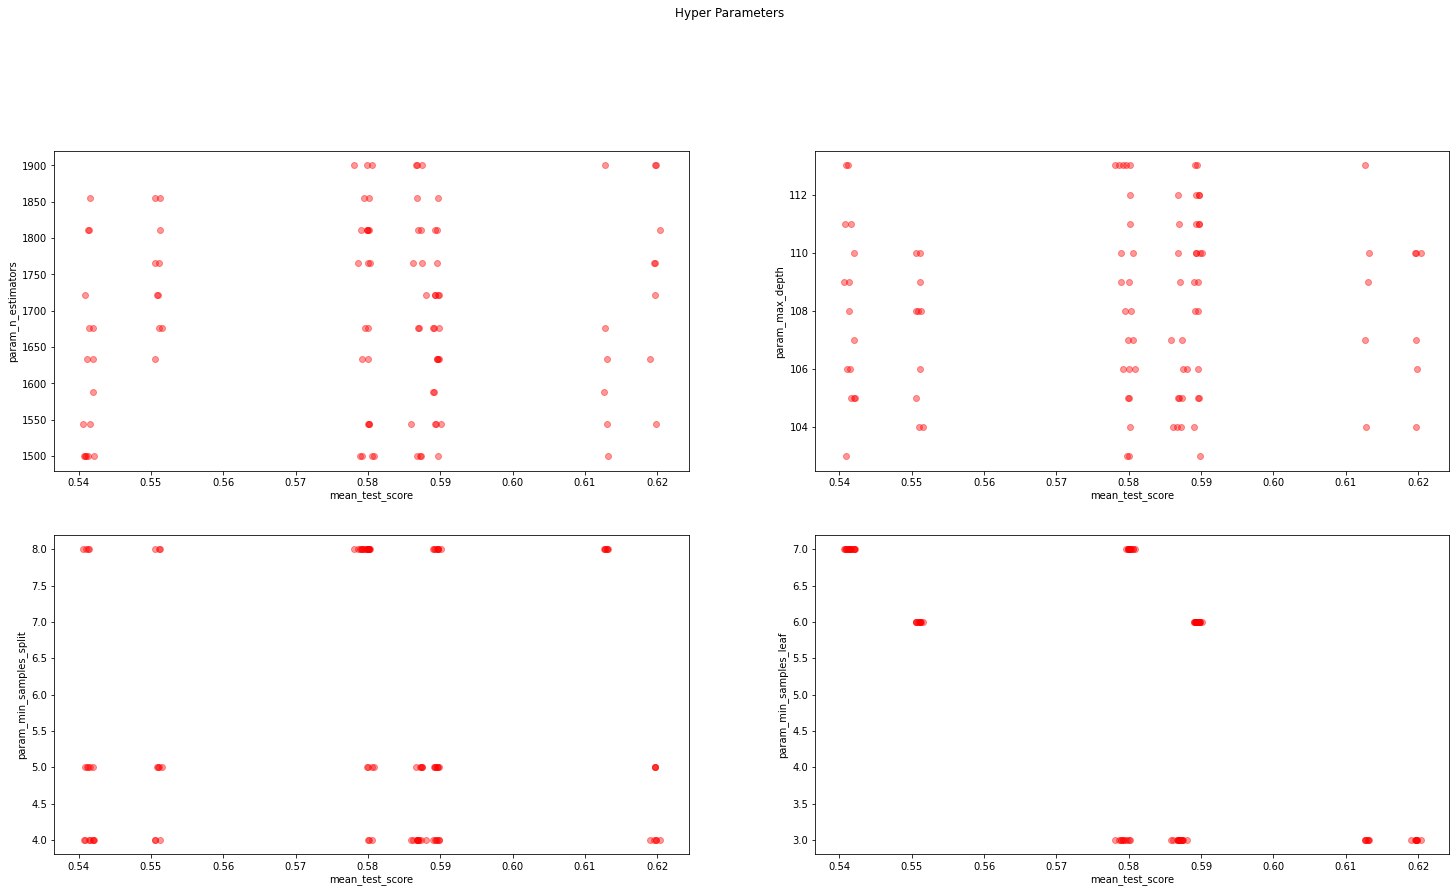

In [90]:
# Plot the hyper-parameters in relation of mean test score
# Values are plotted through dots. The brighter the dot, the more times that value has been chosen by the models.
# On the X axis, the closer the values are to 0 the better they are

h_params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', ]
fig = plt.figure(figsize=(25, 20))
fig.suptitle('Hyper Parameters')
outer = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.2)
for index, h_param in enumerate(h_params):
    ax = plt.Subplot(fig, outer[index])
    ax.scatter(ris['mean_test_score'], ris[h_param], color='red', alpha=0.4, )
    ax.set_ylabel(h_param)
    ax.set_xlabel('mean_test_score')
    # ax.set_ylim(105, 110)
    fig.add_subplot(ax)
fig.show()

## Feature Importance

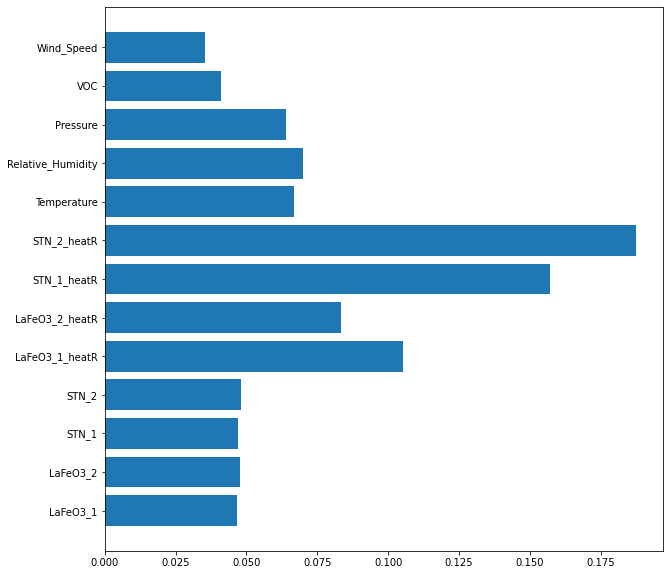

In [91]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns, rf_random.best_estimator_.feature_importances_)
plt.show()

In [ ]:
#Printing the charts to undersand better our predictions

fig,((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

ax1.scatter(Y_test.PM10, rf_random.predict(X_test)[:, 0], label = "PM10")
ax2.scatter(Y_test.CO, rf_random.predict(X_test)[:, 1], label = "CO")
ax3.scatter(Y_test.NO2, rf_random.predict(X_test)[:, 2], label = "NO2")

ax1.set_xlim(0, 120)
ax1.set_ylim(0, 120)
ax2.set_xlim(0, 2.5)
ax2.set_ylim(0, 2.5)
ax3.set_xlim(0.5, 180)
ax3.set_ylim(0.5, 180)

ax1.set_title('PM10')
ax1.set_xlabel('Real data')
ax1.set_ylabel('Prediciton')
ax2.set_title('CO')
ax2.set_xlabel('Real data')
ax2.set_ylabel('Prediciton')
ax3.set_title('NO2')
ax3.set_xlabel('Real Data')
ax3.set_ylabel('Prediction')

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

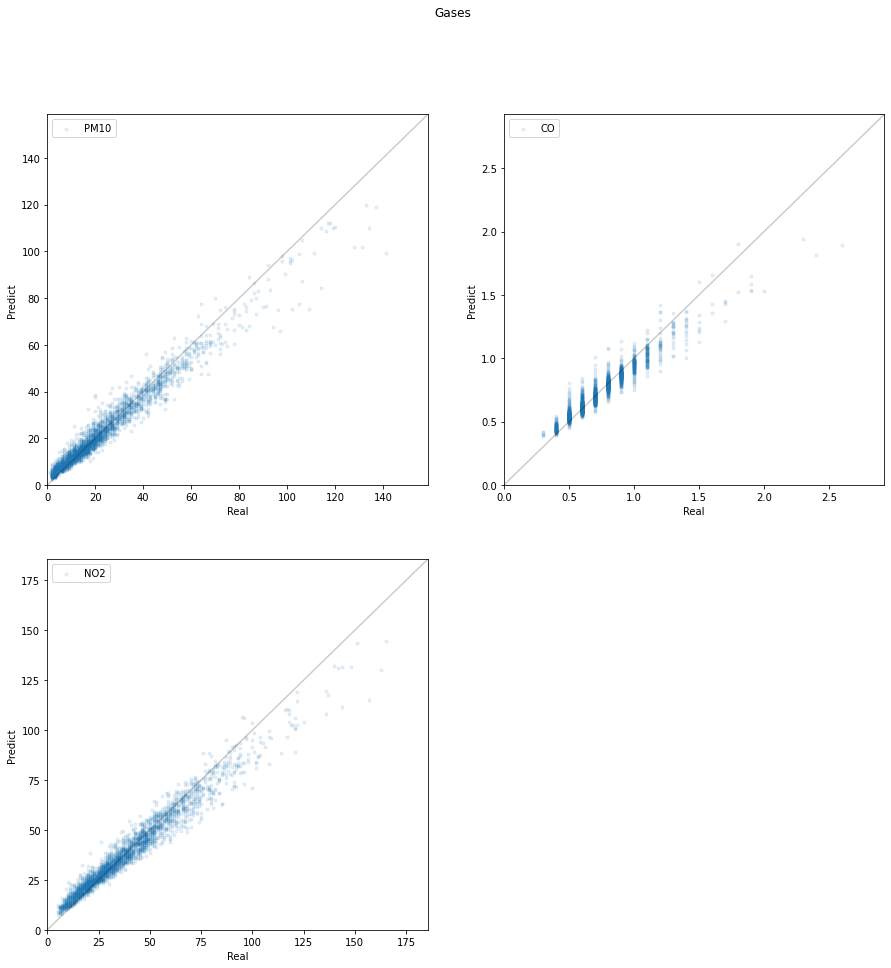

In [93]:
gases = Y_train.columns

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Gases')
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)
for index, gas in enumerate(gases):
    ax = plt.Subplot(fig, outer[index])
    ax.scatter(Y_train[gas], rf_random.predict(X_train)[:,index], marker=".", alpha=0.1, label=gas)
    ax.set_xlabel(f"Real")
    ax.set_ylabel(f"Predict")
    ax.set_xlim(0, Y_train[gas].max()*9/8)
    ax.set_ylim(0, Y_train[gas].max()*9/8)
    ax.plot([-100, Y_train[gas].max()*10], [-100,  Y_train[gas].max()*10], c="k", alpha=0.2)
    ax.legend()
    fig.add_subplot(ax)
fig.show()

In [34]:
appa2.CO.describe()

count    3239.000000
mean        0.724359
std         0.228097
min         0.300000
25%         0.600000
50%         0.700000
75%         0.800000
max         2.600000
Name: CO, dtype: float64

In [35]:
appa2.CO.value_counts()

0.6    735
0.5    584
0.8    536
0.7    417
0.9    399
1.0    171
0.4    152
1.1    112
1.2     45
1.3     28
1.4     21
1.5      8
1.7      7
0.3      7
1.9      5
1.6      4
1.8      3
2.0      2
2.4      1
2.6      1
2.3      1
Name: CO, dtype: int64

In [36]:
Y_train.CO.value_counts()

0.6    584
0.5    471
0.8    427
0.7    332
0.9    320
1.0    143
0.4    127
1.1     87
1.2     33
1.3     21
1.4     16
1.5      7
0.3      6
1.7      4
1.9      4
1.6      3
1.8      2
2.6      1
2.4      1
2.3      1
2.0      1
Name: CO, dtype: int64